In [1]:
from maskmm.ipstartup import *
import os
import glob
from os.path import join
import random
import torch
from torch import load

import skimage.io
from skimage.io import imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random

from maskmm.models.maskrcnn import MaskRCNN
from maskmm import learner
from maskmm.utils import visualize

from maskmm.datasets.nuke.config import Config
from maskmm.datasets.nuke.dataset import Dataset

from maskmm.mytools import *

ROOT_DIR = "/home/ubuntu/maskmm"
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "data/models/mask_rcnn_coco.pth")
DATA = join(expanduser("~"), "data", "nuke") 

class Config(Config):
    NAME = "mm"
    STEPS_PER_EPOCH = 1
    VALIDATION_STEPS = 1
    GPU_COUNT=1
    NPRANDOM = True
config = Config()
rngreset()

[maskmm.ipstartup:INFO]:running ipstartup (ipstartup.py:13, time=18:16)


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

[root:INFO]:starting (cellevents.py:36, time=18:16)


time: 1.12 ms


## Dataset

In [3]:
# create validation sample
pvalid = .2
trainpath = join(DATA, "stage1_train")
df = pd.DataFrame(os.listdir(trainpath), columns=["image"])
df["subset"] = np.random.random(len(df))>pvalid
df.loc[df.subset==True, "subset"] = "train"
df.loc[df.subset==False, "subset"] = "valid"

df.to_pickle(join(DATA, "subset.pkl"))
df.subset.value_counts()

[root:INFO]:starting (cellevents.py:36, time=18:16)


train    505
valid    123
Name: subset, dtype: int64

time: 173 ms


In [4]:
dataset_train = Dataset(config)
dataset_train.load_nuke(trainpath, "train")
dataset_train.prepare()

dataset_val = Dataset(config)
dataset_val.load_nuke(trainpath, "valid")
dataset_val.prepare()

[root:INFO]:starting (cellevents.py:36, time=18:16)


time: 60.6 ms


In [5]:
%%s
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

[root:INFO]:starting (cellevents.py:36, time=18:16)


time: 948 µs


## Create Model

In [6]:
model = MaskRCNN(model_dir=MODEL_DIR, config=config).to(config.DEVICE)
model.initialize_weights()

# load pretrained except final layers that depend on NUM_CLASSES
params = torch.load(COCO_MODEL_PATH)
params.pop('classifier.linear_class.weight')
params.pop("classifier.linear_bbox.weight")
params.pop("mask.conv5.weight")
params.pop('classifier.linear_class.bias')
params.pop("classifier.linear_bbox.bias")
params.pop("mask.conv5.bias")
model.load_state_dict(params, strict=False)
_ = model.to(config.DEVICE)

[root:INFO]:starting (cellevents.py:36, time=18:16)


time: 338 ms


In [11]:
from maskmm.callbacks import Multiloss
from fastai import *

# create and fit model
data = DataBunch.create(dataset_train, dataset_val, bs=1, num_workers=0)
learn = Learner(data, model, callback_fns=[Multiloss], loss_func = lambda x, *y: x)
learn.fit(1, .01)

[root:INFO]:starting (cellevents.py:36, time=18:21)


[root:INFO]:tensor([]) (callbacks.py:27, time=18:21)
[root:INFO]:tensor([]) (callbacks.py:28, time=18:21)
[root:INFO]:[tensor(4694.7197, grad_fn=<NllLossBackward>), tensor(14437.0215, grad_fn=<SmoothL1LossBackward>), tensor([0.]), tensor([0.]), tensor([0.])] (callbacks.py:32, time=18:21)
[root:INFO]:tensor([]) (callbacks.py:27, time=18:21)
[root:INFO]:tensor([]) (callbacks.py:28, time=18:21)
[root:INFO]:[tensor(8099.5176, grad_fn=<NllLossBackward>), tensor(983.1106, grad_fn=<SmoothL1LossBackward>), tensor([0.]), tensor([0.]), tensor([0.])] (callbacks.py:32, time=18:21)


KeyboardInterrupt: 

time: 23.1 s


# maskmm learner

[root:INFO]:starting (cellevents.py:36, time=18:30)



Starting at epoch 1. LR=0.01

Checkpoint Path: /home/ubuntu/maskmm/logs/mm20181025_1816/mask_rcnn_mm_{:04d}.pth
Epoch 1/3.
	1/1 |██████████| 100.0% Complete - loss: 3019.18848 - rpn_class_loss: 1556.24170 - rpn_bbox_loss: 1462.94678 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000

	1/1 |██████████| 100.0% Complete - loss: 136736399644218192621843387951087616.00000 - rpn_class_loss: 90449019390192367216946998583230464.00000 - rpn_bbox_loss: 46287385205785982546417488964354048.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000

Epoch 2/3.
	1/1 |██████████| 100.0% Complete - loss: 14389.26562 - rpn_class_loss: 2230.10205 - rpn_bbox_loss: 12159.16406 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000

	1/1 |██████████| 100.0% Complete - loss: 678361121482435720173053770989568.00000 - rpn_class_loss: 577466609771851112344492529680384.00000 - rpn_bbox_loss: 100894502039178050911527843659776

KeyboardInterrupt: 

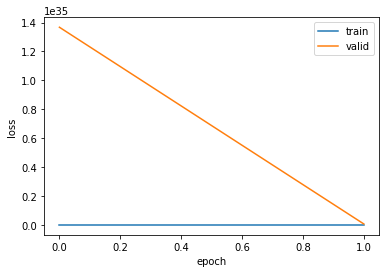

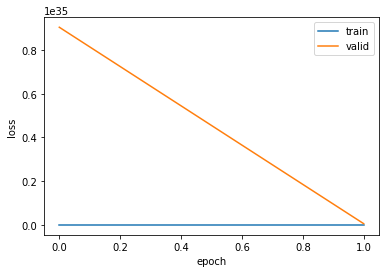

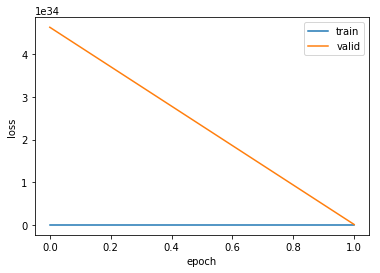

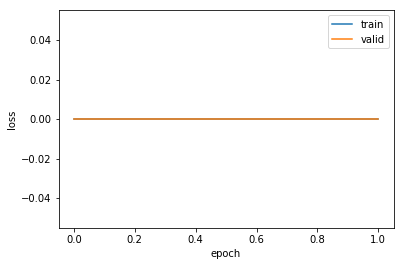

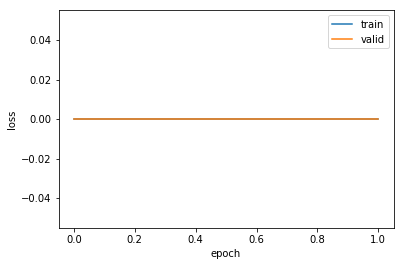

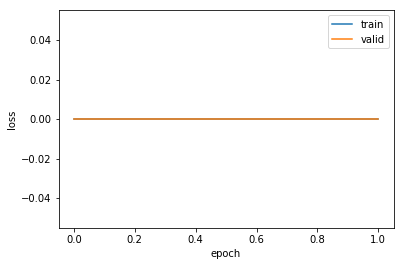

time: 55.5 s


In [17]:
# Create model in training mode
m = learner.Learner(model, dataset_train, dataset_val)
m.train(.01, 3, "heads")

In [ ]:
torch.tensor(config.MEAN_PIXEL, dtype=torch.float).type()

In [ ]:
match("images"), match("gt_boxes")

In [ ]:
match("anchors_pre"), match("gt_boxes_pre"), match("overlaps")

In [ ]:
match("anchors_pre", tol=0), match("gt_boxes_pre", tol=0), match("overlaps", tol=0)

In [ ]:
match("test1"), match("test2"), match("test3")

In [ ]:
match("rpn_match"), match("rpn_bbox")

In [ ]:
match("pre_conv", tol=0), match("post_conv"), match("post_conv", "post_convtest")

In [ ]:
mse(load("inputs1"), load("inputs10"))

In [ ]:
match("inputs0"), match("inputs1"), match("normalized_boxes")

In [ ]:
load("masks").sum(),load("masks0").sum()

In [ ]:
mse(load("masks"),load("masks0"))

In [ ]:
match("proposals"), match("rois"), match("roi_gt_class_ids"), match("deltas"), match("masks")

# timings

In [ ]:
%%s
from maskmm.utils import box_utils
a=load("anchors_pre")
b=load("gt_boxes_pre")
%timeit a=load("anchors_pre")
%timeit b=load("gt_boxes_pre")
%timeit overlaps = box_utils.np_compute_overlaps(a,b)
save(overlaps.numpy(), "overlaps")
match("overlaps")

In [ ]:
%%s
from maskmm.utils import box_utils
a=torch.Tensor(load("anchors_pre")).cpu()
b=torch.Tensor(load("gt_boxes_pre")).cpu()
%timeit a=torch.Tensor(load("anchors_pre")).cpu()
%timeit b=torch.Tensor(load("gt_boxes_pre")).cpu()
%timeit overlaps = box_utils.torch_compute_overlaps(a,b)
save(overlaps.numpy(), "overlaps")
match("overlaps")

In [ ]:
%%s
from maskmm.utils import box_utils
a=torch.Tensor(load("anchors_pre")).cuda()
b=torch.Tensor(load("gt_boxes_pre")).cuda()
%timeit a=torch.Tensor(load("anchors_pre")).cuda()
%timeit b=torch.Tensor(load("gt_boxes_pre")).cuda()
%timeit overlaps = box_utils.torch_compute_overlaps(a,b)
save(overlaps.numpy(), "overlaps")
match("overlaps")